In [364]:
import jax.numpy as jnp
import jax
from jax import grad, hessian, jacobian
import numpy as np
import matplotlib.pyplot as plt

In [373]:
# RBF Kernel function (for each pair of points x, y)
def RBF_kernel(x, y, gamma=0.5):
    return jnp.exp(-gamma * jnp.sum((x - y) ** 2))

# Compute Laplacian w.r.t. y
def laplacian_y(x, y, gamma=0.5):
    hess_y = hessian(lambda y_: RBF_kernel(x, y_, gamma))(y)
    return jnp.trace(hess_y)

def RBF_kernel_batch(X, Y, gamma=0.5):
    kernel_batch = jax.vmap(lambda x: jax.vmap(lambda y: RBF_kernel(x, y))(Y))(X)
    return kernel_batch

# Compute Laplacian_y for each pair in the batch of points X and Y
def laplacian_y_batch(X, Y, gamma=0.5):
    # Compute the Laplacian for each pair (x_i, y_j)
    laplacian_batch = jax.vmap(lambda x: jax.vmap(lambda y: laplacian_y(x, y, gamma))(Y))(X)
    return laplacian_batch

# Compute Laplacian_x Laplacian_y for each pair in the batch of points X and Y
def laplacian_x_laplacian_y_batch(X, Y, gamma=0.5):
    # Vectorize the Laplacian_y computation over both X and Y
    def bilaplacian(x, y):
        return jnp.trace(hessian(lambda x_: laplacian_y(x_, y, gamma))(x))
    # Compute the bi-Laplacian for each pair (x_i, y_j)
    bilaplacian_batch = jax.vmap(lambda x: jax.vmap(lambda y: bilaplacian(x, y))(Y))(X)
    return bilaplacian_batch

In [366]:
def f(x, y):
    return 2*jnp.pi*(jnp.sin(2*np.pi*x))*jnp.cos(2*np.pi*y) 

(220, 220)


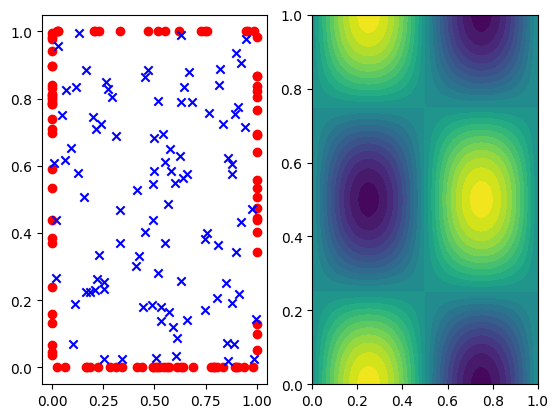

In [378]:
I = 100
B = 100
n_grid = 220
p = 0.5
key1 = jax.random.PRNGKey(0)
key2 = jax.random.PRNGKey(1)


bd1 = jnp.concatenate((jax.random.bernoulli(key1, p=p, shape=(B//2, 1)), jax.random.uniform(key2, shape=(B//2, 1))), axis=1)
bd2 = jnp.concatenate((jax.random.uniform(key1, shape=(B//2, 1)), jax.random.bernoulli(key2, p=p, shape=(B//2, 1))), axis=1)
X_B = jnp.concatenate((bd1, bd2), axis=0)
X_I = jax.random.uniform(key1, shape=(I, 2))

fig, axs = plt.subplots(1, 2, )
axs[0].scatter(X_B[:, 0], X_B[:, 1], color='red', marker='o')
axs[0].scatter(X_I[:, 0], X_I[:, 1], color='blue', marker='x')

x = jnp.linspace(0, 1, n_grid)
y = jnp.linspace(0, 1, n_grid)
X, Y = jnp.meshgrid(x, y)

axs[1].scatter(X, Y, s=0.1)
axs[1].contourf(X, Y, f(X, Y), levels=20)
print(f(X, Y).shape)

Setup $K \alpha = y$

In [381]:
# Should be f(x_1), ... f(x_B) and then on boundary
f_I = f(X_I[:, 0], X_I[:, 1])
f_B = jnp.zeros((X_B.shape[0],))
f_vec = jnp.hstack([f_I, f_B])
print(f_vec.shape)

(200,)


In [382]:
K_II = laplacian_x_laplacian_y_batch(X_I, X_I)
K_IB = laplacian_y_batch(X_B, X_I)
K_BB = RBF_kernel_batch(X_B, X_B)
K = jnp.block([
     [K_II, K_IB.T],
     [K_IB, K_BB]
    ])

alpha = jnp.linalg.solve(K, f_vec)

Solution is given by $u(x) = \bm{\phi}(K(x, \cdot)) K_{\phi\phi}^{-1} y = \bm{\phi}(K(x, \cdot)) \bm{\alpha}$. However, we would like to compute solution on more than one point at a time, say at $\mathcal{X}_{\textrm{test}} = \{x_i\}$. This becomes $$u(\mathcal{X}_{\textrm{test}}) = \bm{\phi}(K(\mathcal{X}_{\textrm{test}}, \cdot)) K_{\phi\phi}^{-1} y$$

(1000, 2) (1000,)


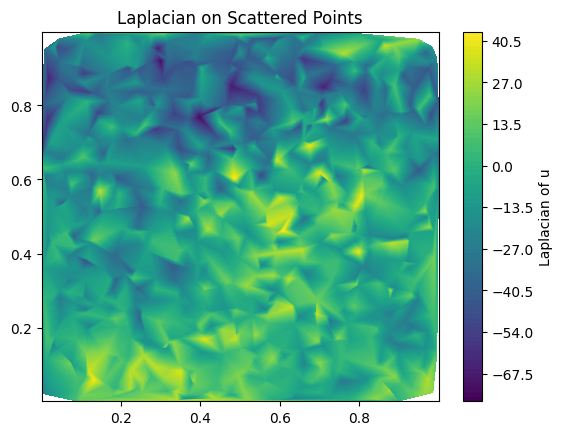

In [406]:
X_test = jax.random.uniform(key, shape=(1000, 2))

def u_prediction(x):
    X_test = x[None, :]  # shape (1, 2)
    basis = jnp.hstack([
        laplacian_y_batch(X_test, X_I), 
        RBF_kernel_batch(X_test, X_B)
    ])
    output = basis @ alpha  # shape (1,)
    return output[0]  # scalar

def u_pred_batch(x):
    return jax.vmap(lambda x_: u_prediction(x_))(x)

def lap_one(x):
    hess = hessian(lambda x_: u_prediction(x_))(x)
    return jnp.trace(hess)

def lap_u(X_test):
    return jax.vmap(lambda x_: lap_one(x_))(X_test)

u_test = u_pred_batch(X_test)
lap_u_test = lap_u(X_test)

print(X_test.shape, lap_u_test.shape)

plt.tricontourf(X_test[:, 0], X_test[:, 1], lap_u_test, levels=100, cmap='viridis')
plt.colorbar(label="Laplacian of u")
plt.title("Laplacian on Scattered Points")
plt.show()